In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
file_path = '../Data/Processed/video_rating.csv'

In [4]:
df = pd.read_csv(file_path, header=0, index_col=[0, 1])

In [5]:
df.dtypes

start_time                     object
end_time                       object
wander_speed                  float64
wander_roundness              float64
wander_roundness_effective    float64
wander_cycle_rate             float64
blink_temperature             float64
blink_slope                   float64
blink_cycle_rate              float64
beep_pitch                    float64
beep_slope                    float64
beep_cycle_rate               float64
joy_intensity                 float64
sadness_intensity             float64
fear_intensity                float64
anger_intensity               float64
disgust_intensity             float64
surprise_intensity            float64
other_emotion                  object
other_intensity               float64
pleasure                        int64
arousal                         int64
dominance                       int64
appraisal                      object
dtype: object

In [6]:
df.fillna(0, inplace=True)

In [7]:
df.drop(columns=['other_emotion', 'other_intensity'], inplace=True)

In [8]:
include_wander_effective_roundness = False

In [9]:
if include_wander_effective_roundness:
    independent_variables = ['wander_speed', 'wander_roundness', 'wander_roundness_effective', 'wander_cycle_rate', 'blink_temperature', 'blink_slope', 'blink_cycle_rate', 'beep_pitch', 'beep_slope', 'beep_cycle_rate']
else:
    independent_variables = ['wander_speed', 'wander_roundness', 'wander_cycle_rate', 'blink_temperature', 'blink_slope', 'blink_cycle_rate', 'beep_pitch', 'beep_slope', 'beep_cycle_rate']

In [10]:
continuous_independent_variables = independent_variables.copy()
continuous_independent_variables.remove('blink_slope')
continuous_independent_variables.remove('beep_slope')

In [11]:
# Define the list of rating column
intensity_columns = ['joy_intensity', 'sadness_intensity', 'anger_intensity', 'fear_intensity', 'disgust_intensity', 'surprise_intensity']
sam_columns = ['pleasure', 'arousal', 'dominance']
dependent_variables = intensity_columns + sam_columns + ['appraisal']
dependent_categorical_variables = intensity_columns + sam_columns

In [12]:
num_independent_variables = len(independent_variables)
num_dependent_categorical_variables = len(dependent_categorical_variables)

In [13]:
for col in intensity_columns:
    df[col] = pd.Categorical(df[col].astype(int), ordered=True)

In [14]:
for col in sam_columns:
    df[col] = pd.Categorical(df[col].astype(int), ordered=True)

In [15]:
df

start_time      end_time  wander_speed  \
participant_id           video_id                                             
5588b2bffdf99b7a7714efd1 22        5/8/24 22:59  5/8/24 23:40     62.775115   
                         43        5/8/24 22:59  5/8/24 23:40     61.110970   
                         50        5/8/24 22:59  5/8/24 23:40     46.017272   
                         84        5/8/24 22:59  5/8/24 23:40     78.659842   
                         125       5/8/24 22:59  5/8/24 23:40     74.946312   
...                                         ...           ...           ...   
6613a814a0c2d6cb21da8ef8 279       5/8/24 21:33  5/8/24 22:09     30.321874   
                         387       5/8/24 21:33  5/8/24 22:09     52.342993   
                         423       5/8/24 21:33  5/8/24 22:09     37.922254   
                         467       5/8/24 21:33  5/8/24 22:09     49.408758   
                         478       5/8/24 21:33  5/8/24 22:09     55.832759   

                                   wander_roundness  \
participant_id           video_id                     
5588b2bffdf99b7a7714efd1 22                0.688911   
                         43                0.352980   
                         50                0.530403   
                         84                0.963506   
                         125               0.498299   
...                                             ...   
6613a814a0c2d6cb21da8ef8 279               0.203517   
                         387               0.496135   
                         423               0.283549   
                         467               0.420447   
                         478               0.652202   

                                   wander_roundness_effective  \
participant_id           video_id                               
5588b2bffdf99b7a7714efd1 22                          0.178370   
                         43                          0.076109   
                         50                          0.154840   
                         84                          0.239340   
                         125                         0.143700   
...                                                       ...   
6613a814a0c2d6cb21da8ef8 279                         0.034468   
                         387                         0.213351   
                         423                         0.150125   
                         467                         0.087419   
                         478                         0.245419   

                                   wander_cycle_rate  blink_temperature  \
participant_id           video_id                                         
5588b2bffdf99b7a7714efd1 22                 3.862264           0.504496   
                         43                 4.637822           0.929641   
                         50                 3.425497           0.943638   
                         84                 4.025686           0.931626   
                         125                3.467634           0.330719   
...                                              ...                ...   
6613a814a0c2d6cb21da8ef8 279                5.904459           0.464465   
                         387                2.325440           0.086675   
                         423                1.888757           0.400462   
                         467                4.809581           0.447571   
                         478                2.657507           0.231250   

                                   blink_slope  blink_cycle_rate  beep_pitch  \
participant_id           video_id                                              
5588b2bffdf99b7a7714efd1 22                0.0          4.403772  123.816519   
                         43                0.0          3.738390  773.537894   
                         50                1.0          2.511475  598.384259   
                         84                0.0          0.646983  689.6

In [16]:
datetime_format = '%m/%d/%y %H:%M'

df["start_time"] = pd.to_datetime(df["start_time"], format=datetime_format)
df["end_time"] = pd.to_datetime(df["end_time"], format=datetime_format)

In [17]:
df.dtypes

start_time                    datetime64[ns]
end_time                      datetime64[ns]
wander_speed                         float64
wander_roundness                     float64
wander_roundness_effective           float64
wander_cycle_rate                    float64
blink_temperature                    float64
blink_slope                          float64
blink_cycle_rate                     float64
beep_pitch                           float64
beep_slope                           float64
beep_cycle_rate                      float64
joy_intensity                       category
sadness_intensity                   category
fear_intensity                      category
anger_intensity                     category
disgust_intensity                   category
surprise_intensity                  category
pleasure                            category
arousal                             category
dominance                           category
appraisal                             object
dtype: obj

In [18]:
df.describe(include='category')

joy_intensity  sadness_intensity  fear_intensity  anger_intensity  \
count            3160               3160            3160             3160   
unique              6                  6               6                6   
top                 0                  0               0                0   
freq              986               1068            1173             1404   

        disgust_intensity  surprise_intensity  pleasure  arousal  dominance  
count                3160                3160      3160     3160       3160  
unique                  6                   6         9        9          9  
top                     0                   0         3        5          5  
freq                 1676                1084       608      609        616

In [19]:
titles = {'wander_speed': 'Wander Speed', 'wander_roundness': 'Wander Roundness', 'wander_roundness_effective': 'Wander Effective Roundness', 'wander_cycle_rate': 'Wander Cycle Rate', 
          'blink_temperature': 'Blink Temperature', 'blink_slope': 'Blink Slope', 'blink_cycle_rate': 'Blink Cycle Rate', 
          'beep_pitch': 'Beep Pitch', 'beep_slope': 'Beep Slope', 'beep_cycle_rate': 'Beep Cycle Rate',
          'joy_intensity': 'Joy Intensity', 'sadness_intensity': 'Sadness Intensity', 'anger_intensity': 'Anger Intensity', 
          'fear_intensity': 'Fear Intensity', 'disgust_intensity': 'Disgust Intensity', 'surprise_intensity': 'Surprise Intensity',
          'pleasure': 'Pleasure', 'arousal': 'Arousal', 'dominance': 'Dominance'}

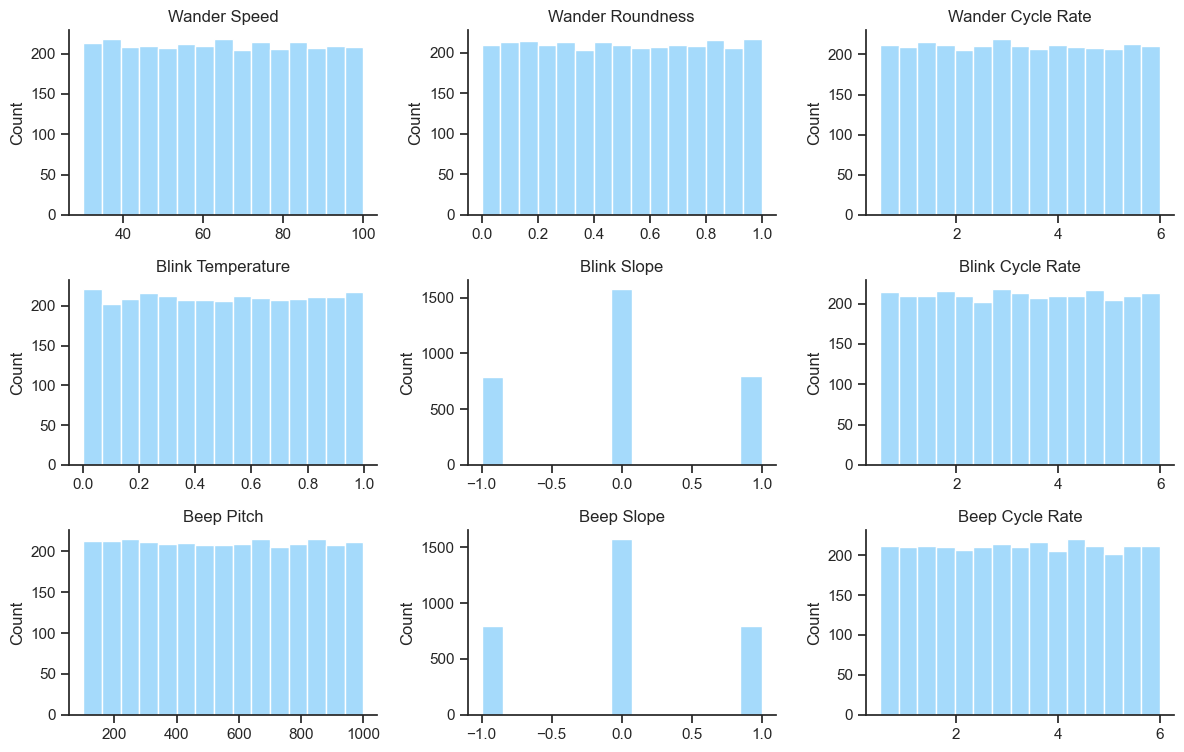

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for ax, independent_variable in zip(axes.flatten(), independent_variables):
    # Create the histplot in the specified subplot
    sns.histplot(data=df, x=independent_variable, ax=ax, color='lightskyblue')
    ax.set_title(titles[independent_variable])
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

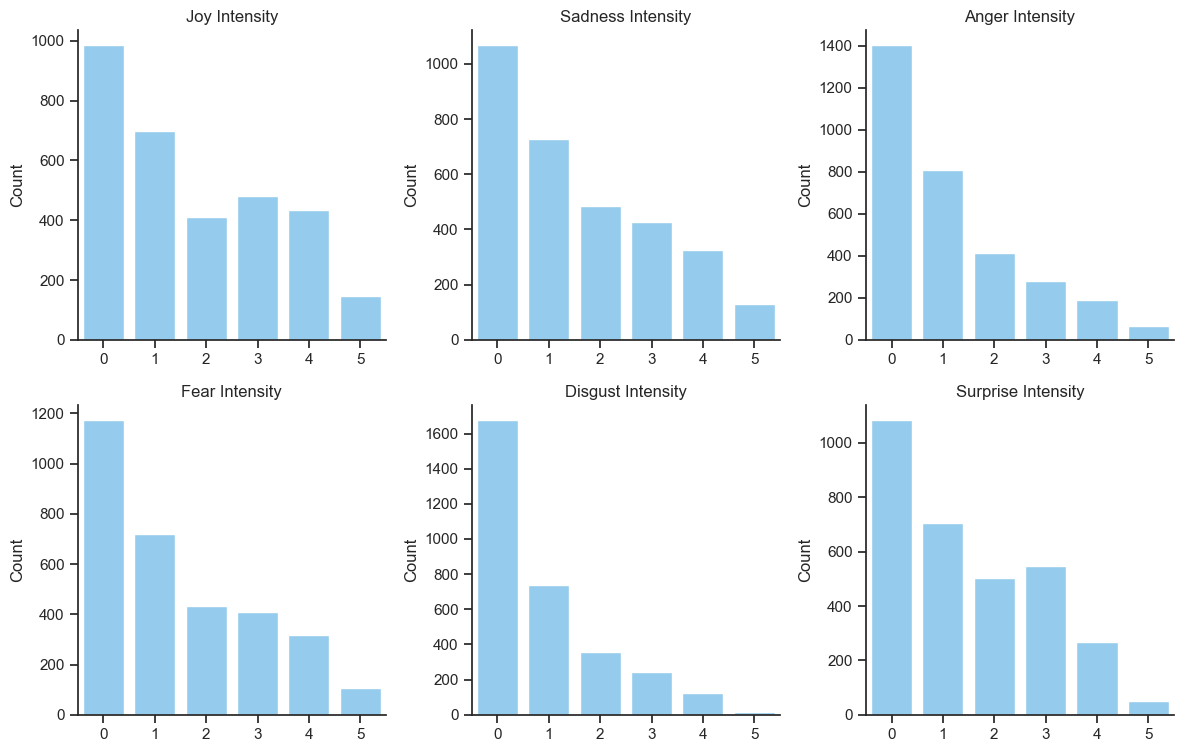

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, dependent_variable in zip(axes.flatten(), intensity_columns):
    # Create the catplot in the specified subplot
    sns.countplot(data=df, x=dependent_variable, ax=ax, color='lightskyblue')
    ax.set_title(titles[dependent_variable])
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

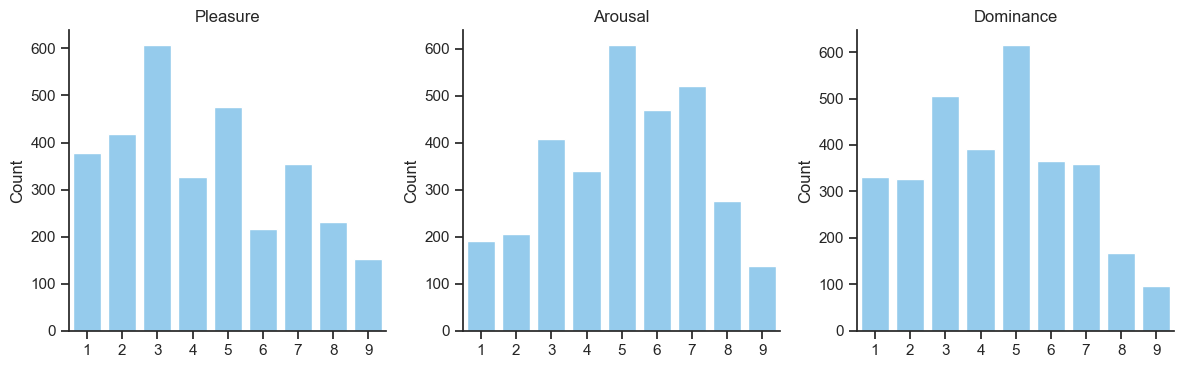

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, dependent_variable in zip(axes.flatten(), sam_columns):
    # Create the catplot in the specified subplot
    sns.countplot(data=df, x=dependent_variable, ax=ax, color='lightskyblue')
    ax.set_title(titles[dependent_variable])
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

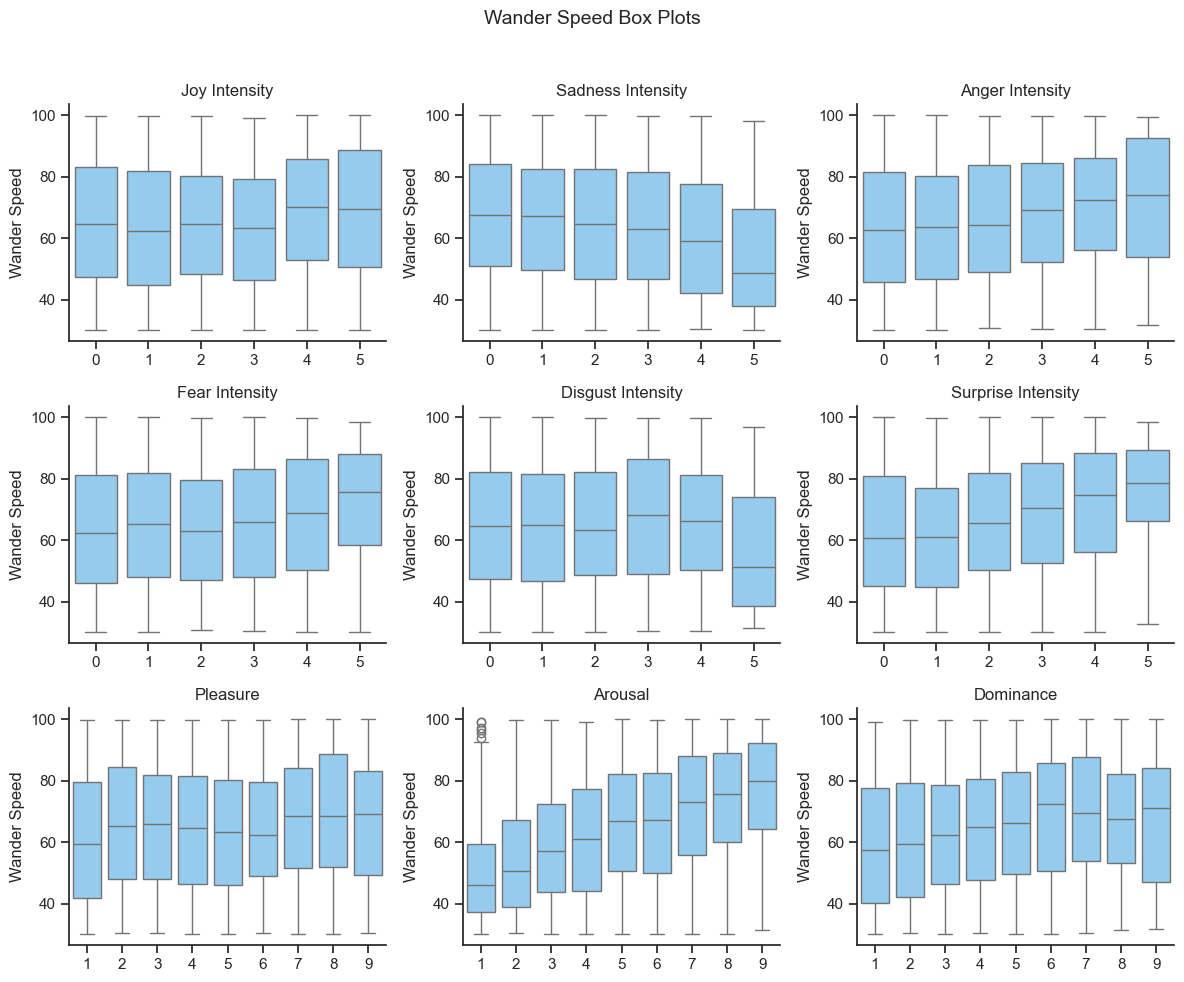

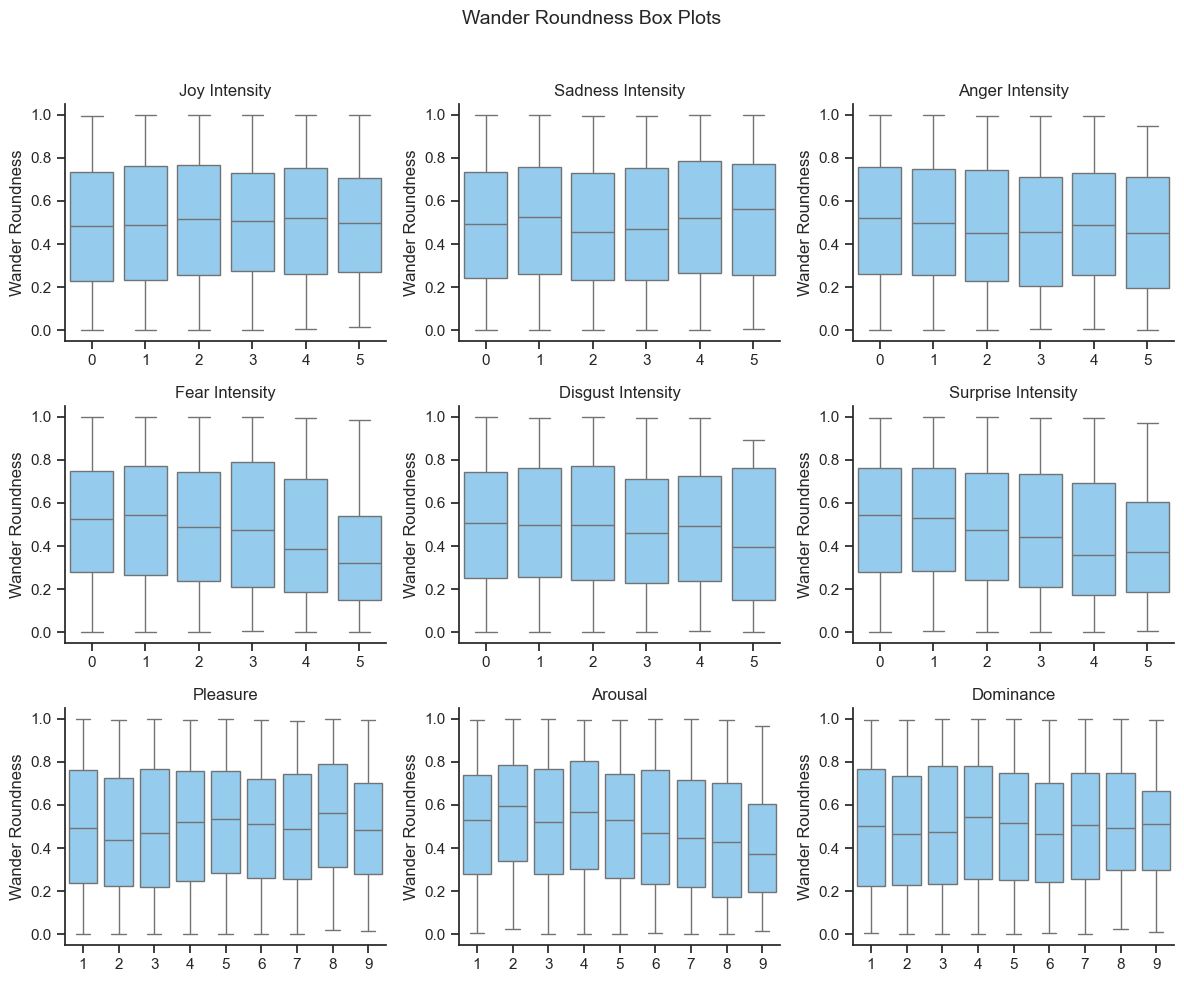

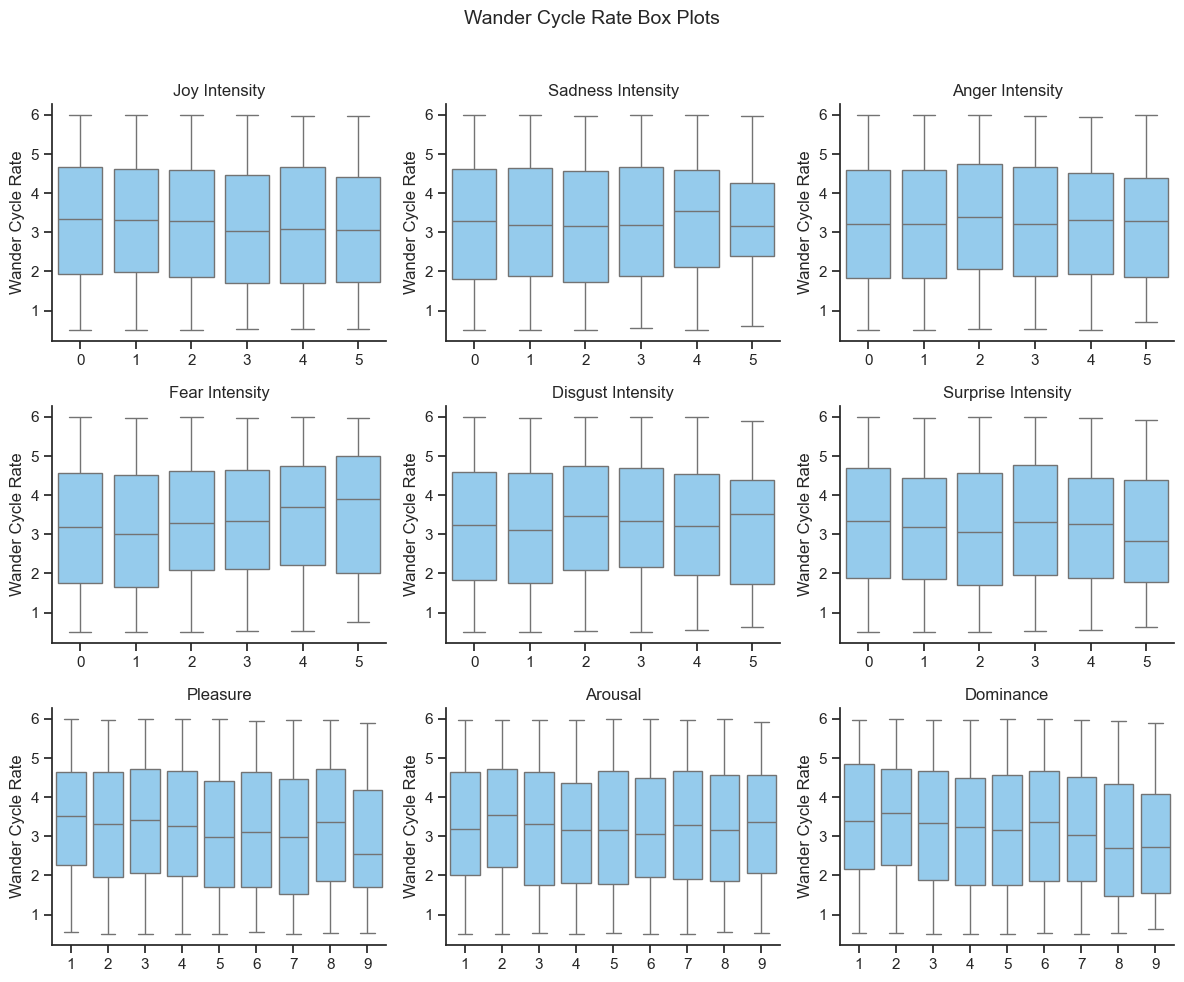

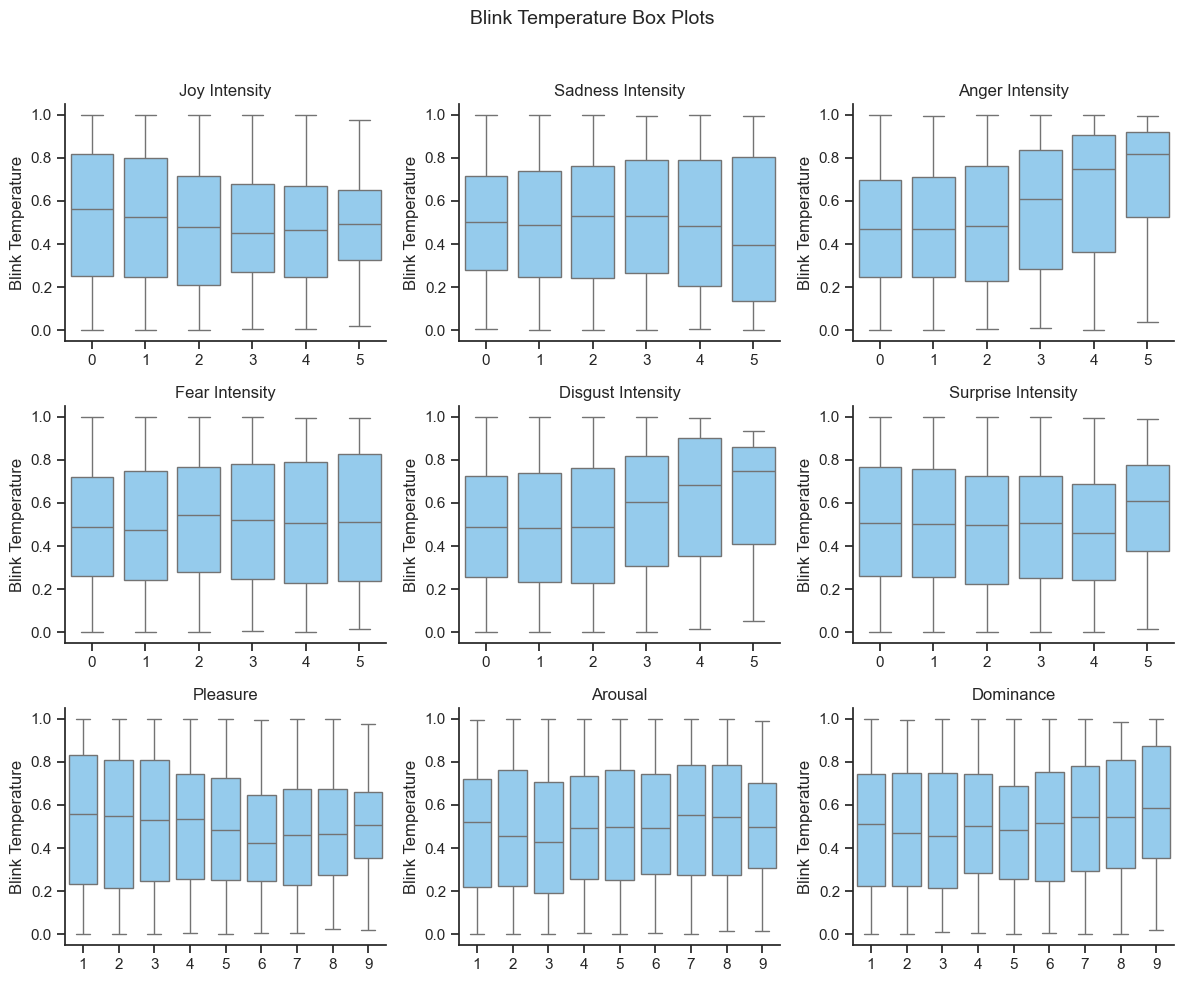

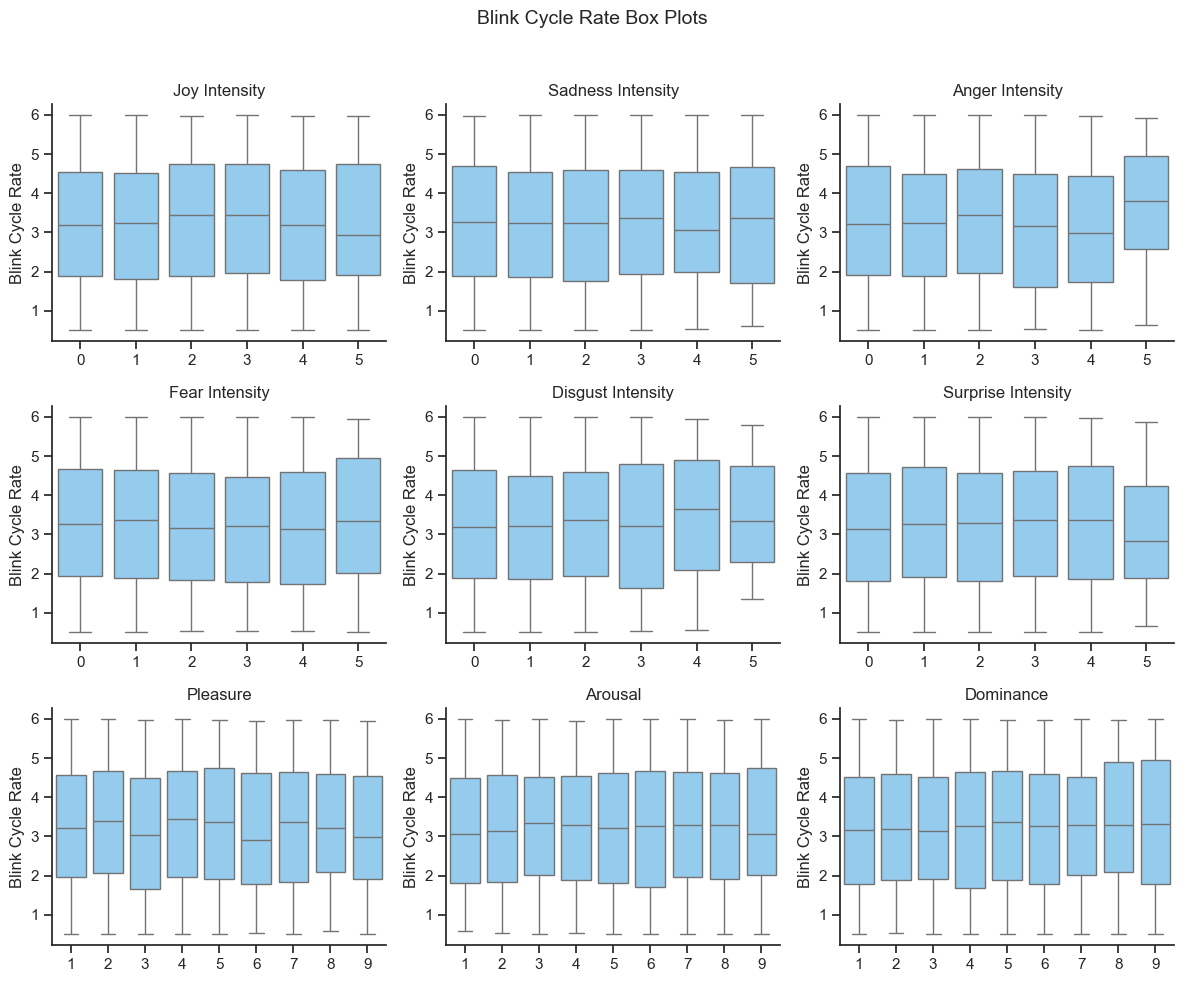

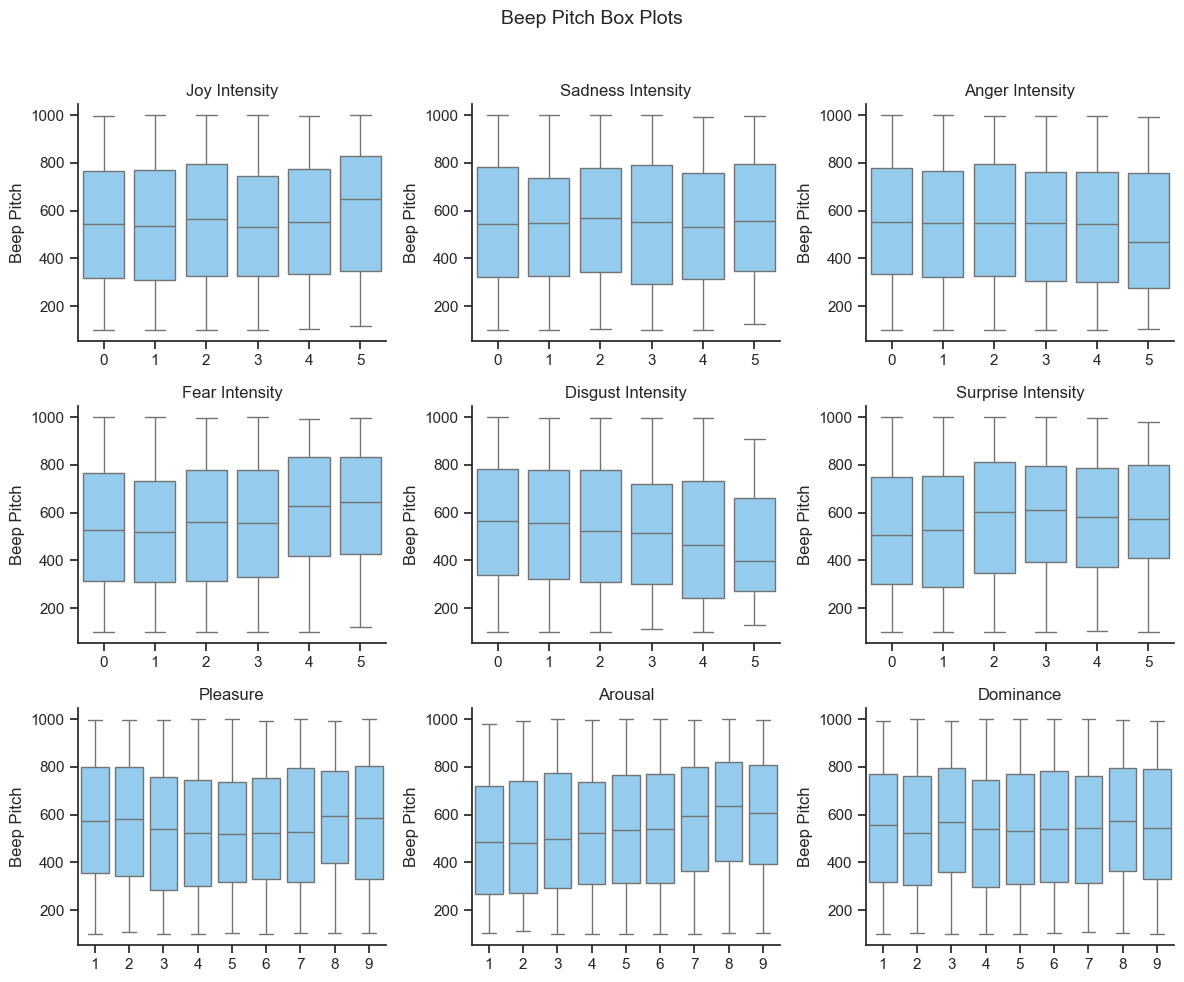

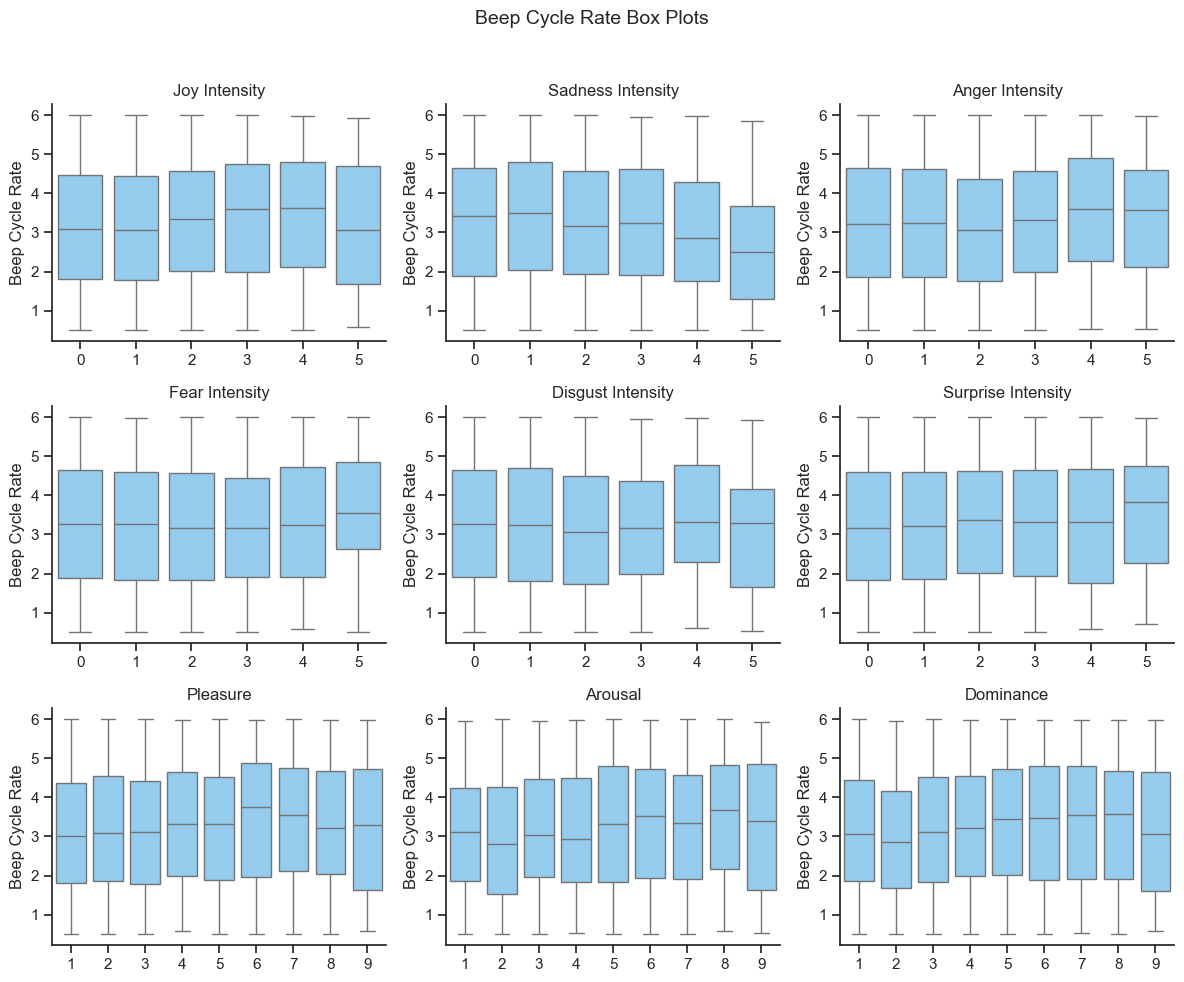

In [23]:
for independent_variable in continuous_independent_variables:
    # Create a new figure for each video
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle(f'{titles[independent_variable]} Box Plots', fontsize=14)
    
    for ax, dependent_variable in zip(axes.flatten(), dependent_categorical_variables):
        sns.boxplot(data=df, x=dependent_variable, y=independent_variable, ax=ax, color='lightskyblue')
        ax.set_title(titles[dependent_variable])
        ax.set_xlabel('')
        ax.set_ylabel(titles[independent_variable])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [24]:
# for video in range(1, 513):
#     fig, axes = plt.subplots(3, 3, figsize=(12, 6))
#     fig.suptitle(f'Video {video}', fontsize=14)

#     for ax, dependent_variable in zip(axes.flatten(), dependent_categorical_variables):
#         # Filter data for current video
#         video_data = df.xs(video, level='video_id')

#         if not video_data[dependent_variable].dropna().empty:
#             # Boxplot with outliers
#             sns.boxplot(data=video_data, x=dependent_variable, ax=ax, color='lightskyblue')

#             # Overlay with a swarmplot to show individual points
#             sns.swarmplot(data=video_data, x=dependent_variable, ax=ax, color='black', alpha=0.5)

#             ax.set_title(titles[dependent_variable])
#             ax.set_xlabel('')
#             ax.set_ylabel('')
#         else:
#             ax.set_title(titles[dependent_variable] + " (No data)")
#             ax.set_xlabel('')
#             ax.set_ylabel('')

#     plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
#     plt.show()

In [25]:
# Make a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()

# Convert categorical variables to numeric codes
for col in dependent_categorical_variables:
    df_encoded[col] = df_encoded[col].dropna().cat.codes

In [26]:
df_encoded

start_time            end_time  \
participant_id           video_id                                           
5588b2bffdf99b7a7714efd1 22       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         43       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         50       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         84       2024-05-08 22:59:00 2024-05-08 23:40:00   
                         125      2024-05-08 22:59:00 2024-05-08 23:40:00   
...                                               ...                 ...   
6613a814a0c2d6cb21da8ef8 279      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         387      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         423      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         467      2024-05-08 21:33:00 2024-05-08 22:09:00   
                         478      2024-05-08 21:33:00 2024-05-08 22:09:00   

                                   wander_speed  wander_roundness  \
participant_id           video_id                                   
5588b2bffdf99b7a7714efd1 22           62.775115          0.688911   
                         43           61.110970          0.352980   
                         50           46.017272          0.530403   
                         84           78.659842          0.963506   
                         125          74.946312          0.498299   
...                                         ...               ...   
6613a814a0c2d6cb21da8ef8 279          30.321874          0.203517   
                         387          52.342993          0.496135   
                         423          37.922254          0.283549   
                         467          49.408758          0.420447   
                         478          55.832759          0.652202   

                                   wander_roundness_effective  \
participant_id           video_id                               
5588b2bffdf99b7a7714efd1 22                          0.178370   
                         43                          0.076109   
                         50                          0.154840   
                         84                          0.239340   
                         125                         0.143700   
...                                                       ...   
6613a814a0c2d6cb21da8ef8 279                         0.034468   
                         387                         0.213351   
                         423                         0.150125   
                         467                         0.087419   
                         478                         0.245419   

                                   wander_cycle_rate  blink_temperature  \
participant_id           video_id                                         
5588b2bffdf99b7a7714efd1 22                 3.862264           0.504496   
                         43                 4.637822           0.929641   
                         50                 3.425497           0.943638   
                         84                 4.025686           0.931626   
                         125                3.467634           0.330719   
...                                              ...                ...   
6613a814a0c2d6cb21da8ef8 279                5.904459           0.464465   
                         387                2.325440           0.086675   
                         423                1.888757           0.400462   
                         467                4.809581           0.447571   
                         478                2.657507           0.231250   

                                   blink_slope  blink_cycle_rate  beep_pitch  \
participant_id           video_id                                              
5588b2bffdf99b7a7714efd1 22                0.0          4.403772  123.816519   
                         43                0.0          3.738390  773.537894   
 

In [27]:
# Prepare the outlier counts DataFrame
participant_ids = df_encoded.index.get_level_values('participant_id').unique()
outlier_counts = pd.DataFrame(0, index=participant_ids, columns=dependent_categorical_variables)

for video in range(1, 513):
    # Extract data for this video and make a copy
    video_data = df_encoded.xs(video, level='video_id').copy()

    for dependent_variable in dependent_categorical_variables:
        if dependent_variable in video_data.columns:
            # Ensure data is not NA
            clean_data = video_data[dependent_variable].dropna()

            # Compute the quantiles and IQR only if data is present
            if not clean_data.empty:
                q1 = clean_data.quantile(0.25)
                q3 = clean_data.quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr

                # Identify outliers
                outliers = video_data[(video_data[dependent_variable] < lower_bound) | 
                                      (video_data[dependent_variable] > upper_bound)]

                # Count outliers per participant
                for participant in outliers.index:
                    outlier_counts.loc[participant, dependent_variable] += 1

# Filling NaN with 0s for participants with no outliers
outlier_counts.fillna(0, inplace=True)
# Cast all columns to integers
outlier_counts = outlier_counts.astype(int)
# Get the total number of outliers per participant
outlier_counts['total'] = outlier_counts.sum(axis=1)

In [28]:
outlier_counts[outlier_counts.total > 9]

joy_intensity  sadness_intensity  anger_intensity  \
participant_id                                                                
58aca85e0da7f10001de92d4              0                  2                3   
5ea597859b1fb6594ac2b470              2                  0                0   
5f0cfeef098f1e53ff201909              1                  2                0   
5f0f7fe1d7ad1c000b42d091              0                  1                4   
63d3fb730f03adf8b4a28a37              0                  1                2   
645920abcee1cd09e70057cd              1                  1                0   
6508518b906002118153f087              2                  2                3   
653fcb1b0f5d689c00a97629              1                  1                2   
654983b42d3870e2a88c6fe4              2                  1                1   
6565f3b379d54150868b89d8              0                  2                3   
65a04bff3f91fc3cf7f3991b              2                  2                1   
65bd29a33fe10dcc8e183b52              3                  0                0   
65c3a03ff621c50711765546              1                  3                2   
65de18036cf5d10beb26c723              0                  2                0   
66082366bf2c333472dfc339              1                  2                2   

                          fear_intensity  disgust_intensity  \
participant_id                                                
58aca85e0da7f10001de92d4               2                  2   
5ea597859b1fb6594ac2b470               2                  1   
5f0cfeef098f1e53ff201909               2                  1   
5f0f7fe1d7ad1c000b42d091               1                  3   
63d3fb730f03adf8b4a28a37               0                  3   
645920abcee1cd09e70057cd               0                  1   
6508518b906002118153f087               0                  1   
653fcb1b0f5d689c00a97629               1                  2   
654983b42d3870e2a88c6fe4               1                  0   
6565f3b379d54150868b89d8               2                  2   
65a04bff3f91fc3cf7f3991b               1                  2   
65bd29a33fe10dcc8e183b52               0                  2   
65c3a03ff621c50711765546               2                  3   
65de18036cf5d10beb26c723               0                  0   
66082366bf2c333472dfc339               2                  0   

                          surprise_intensity  pleasure  arousal  dominance  \
participant_id                                                               
58aca85e0da7f10001de92d4                   1         1        0          0   
5ea597859b1fb6594ac2b470                   1         0        3          1   
5f0cfeef098f1e53ff201909                   3         2        2          1   
5f0f7fe1d7ad1c000b42d091                   1         0        0          0   
63d3fb730f03adf8b4a28a37                   2         0        0          2   
645920abcee1cd09e70057cd                   0         2        1          4   
6508518b906002118153f087                   1         1        0          0   
653fcb1b0f5d689c00a97629                   1         1        1          1   
654983b42d3870e2a88c6fe4                   1         3        1          0   
6565f3b379d54150868b89d8                   1         0        2          1   
65a04bff3f91fc3cf7f3991b                   0         3        0          1   
65bd29a33fe10dcc8e183b52                   2         2        0          1   
65c3a03ff621c50711765546                   1         1        0          0   
65de18036cf5d10beb26c723                   0         2        3          3   
66082366bf2c333472dfc339                   1         1        1          0   

                          total  
participant_id                   
58aca85e0da7f10001de92d4     11  
5ea597859b1fb6594ac2b470     10  
5f0cfeef098f1e53ff201909     14  
5f0f7fe1d7ad1c000b42d091     10  
63d3fb730f03adf8b4a28a37     10  
645920abcee1cd09e70057cd     10  
6508518b906

In [29]:
corr_matrix = df_encoded[independent_variables + dependent_categorical_variables].corr(method='spearman')

In [30]:
corr_matrix

wander_speed  wander_roundness  wander_cycle_rate  \
wander_speed            1.000000          0.001045          -0.000859   
wander_roundness        0.001045          1.000000           0.000386   
wander_cycle_rate      -0.000859          0.000386           1.000000   
blink_temperature      -0.000009         -0.009557          -0.004262   
blink_slope            -0.003685          0.003874           0.003355   
blink_cycle_rate        0.007109         -0.000167          -0.001364   
beep_pitch              0.004330          0.004486          -0.002976   
beep_slope             -0.001938          0.003104          -0.002798   
beep_cycle_rate         0.003004          0.000837          -0.001130   
joy_intensity           0.042676          0.032255          -0.040603   
sadness_intensity      -0.116750          0.016195           0.019702   
anger_intensity         0.086258         -0.045516           0.020820   
fear_intensity          0.069216         -0.078330           0.065775   
disgust_intensity       0.018511         -0.013421           0.025149   
surprise_intensity      0.143937         -0.103930          -0.013872   
pleasure                0.058254          0.040613          -0.068269   
arousal                 0.309344         -0.101510          -0.000937   
dominance               0.139036          0.000842          -0.071483   

                    blink_temperature  blink_slope  blink_cycle_rate  \
wander_speed                -0.000009    -0.003685          0.007109   
wander_roundness            -0.009557     0.003874         -0.000167   
wander_cycle_rate           -0.004262     0.003355         -0.001364   
blink_temperature            1.000000     0.004498         -0.003276   
blink_slope                  0.004498     1.000000          0.001700   
blink_cycle_rate            -0.003276     0.001700          1.000000   
beep_pitch                  -0.000857    -0.000051          0.003256   
beep_slope                  -0.002574    -0.003785         -0.001970   
beep_cycle_rate             -0.000068     0.001969          0.003604   
joy_intensity               -0.092573    -0.018589          0.018047   
sadness_intensity           -0.003490    -0.018421          0.000214   
anger_intensity              0.125875     0.006820         -0.007963   
fear_intensity               0.034434    -0.017148         -0.007549   
disgust_intensity            0.059716    -0.003374          0.019361   
surprise_intensity          -0.019960    -0.028878          0.027070   
pleasure                    -0.079247    -0.007666          0.000755   
arousal                      0.058577    -0.001298          0.017241   
dominance                    0.057878    -0.006670          0.021544   

                    beep_pitch  beep_slope  beep_cycle_rate  joy_intensity  \
wander_speed          0.004330   -0.001938         0.003004       0.042676   
wander_roundness      0.004486    0.003104         0.000837       0.032255   
wander_cycle_rate    -0.002976   -0.002798        -0.001130      -0.040603   
blink_temperature    -0.000857   -0.002574        -0.000068      -0.092573   
blink_slope          -0.000051   -0.003785         0.001969      -0.018589   
blink_cycle_rate      0.003256   -0.001970         0.003604       0.018047   
beep_pitch            1.000000   -0.005475         0.000532       0.031491   
beep_slope           -0.005475    1.000000         0.001867       0.073525   
beep_cycle_rate       0.000532    0.001867         1.000000       0.065419   
joy_intensity         0.031491    0.073525         0.065419       1.000000   
sadness_intensity    -0.000450   -0.082377        -0.056127      -0.279348   
anger_intensity      -0.024441   -0.018255         0.011928      -0.150377   
fear_intensity        0.070647    0.014293         0.007111      -0.234817   
disgust_intensity    -0.052736   -0.014220        -0.003724      -0.053711   
surprise_intensity    0.099600    0.095669         0.023224       0.273051   
pleasure       

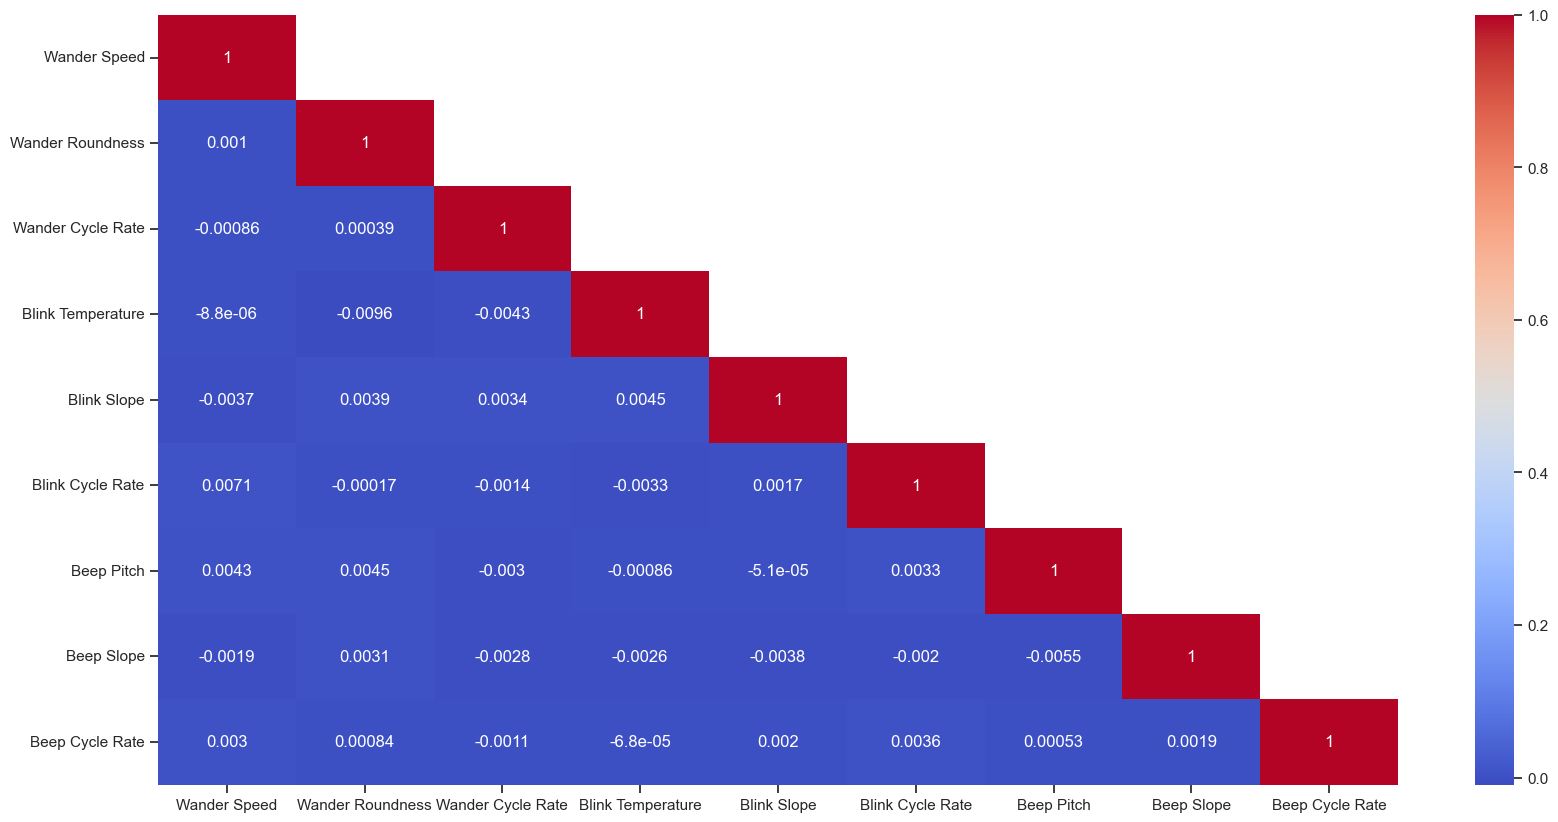

In [31]:
plt.figure(figsize=(20, 10))
ticklabels = [titles[var] for var in independent_variables]
sns.heatmap(corr_matrix.iloc[:num_independent_variables, :num_independent_variables], mask=np.triu(np.ones_like(corr_matrix.iloc[:num_independent_variables, :num_independent_variables], dtype=bool), k=1), annot=True, xticklabels=ticklabels, yticklabels=ticklabels, cmap='coolwarm')
plt.show()

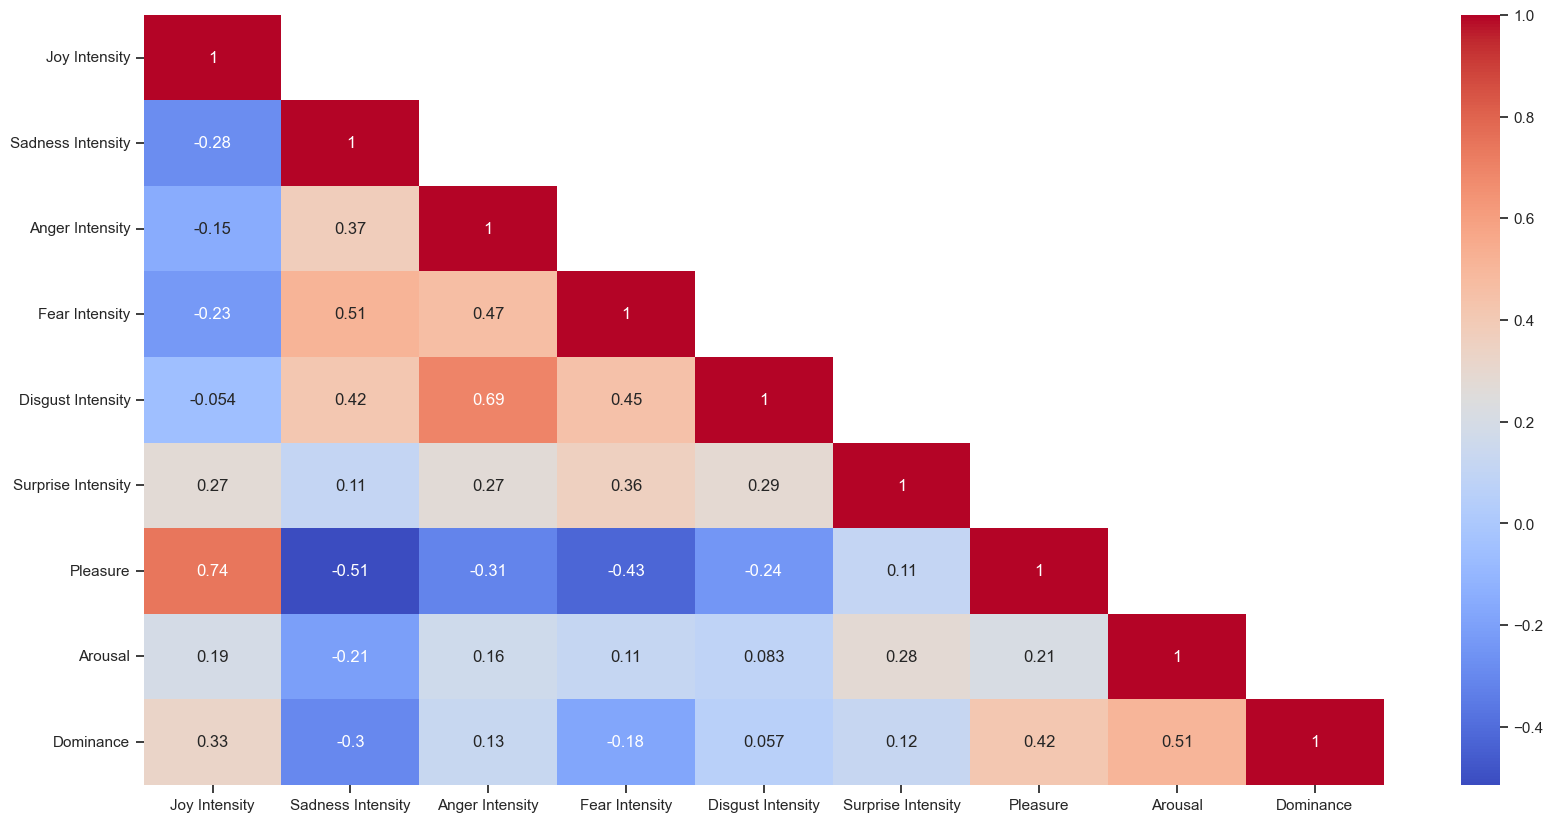

In [32]:
plt.figure(figsize=(20, 10))
ticklabels = [titles[var] for var in dependent_categorical_variables]
sns.heatmap(corr_matrix.iloc[num_independent_variables:, num_independent_variables:], mask=np.triu(np.ones_like(corr_matrix.iloc[num_independent_variables:, num_independent_variables:], dtype=bool), k=1), annot=True, xticklabels=ticklabels, yticklabels=ticklabels, cmap='coolwarm')
plt.show()

In [33]:
def spearman_rho_test(df, independent_variables, dependent_categorical_variables, alpha=0.05, bonferroni_correction=False, benjamini_hochberg_correction=False):
    data = []
    p_values_non_zero = []
    p_values_positive = []
    p_values_negative = []

    if bonferroni_correction and benjamini_hochberg_correction:
        raise Exception("You can only apply one multiple-testing correction.")
    elif bonferroni_correction:
        method = 'bonferroni'
    elif benjamini_hochberg_correction:
        method = 'fdr_bh'
    else:
        method = None  # No correction

    for independent_variable in independent_variables:
        for dependent_variable in dependent_categorical_variables:
            # Calculate Spearman correlation for two-sided test
            rho, p_non_zero = stats.spearmanr(df_encoded[independent_variable], df_encoded[dependent_variable], nan_policy='omit', alternative='two-sided')
            
            # Calculate Spearman correlation for one-sided tests
            _, p_negative = stats.spearmanr(df_encoded[independent_variable], df_encoded[dependent_variable], nan_policy='omit', alternative='less')
            _, p_positive = stats.spearmanr(df_encoded[independent_variable], df_encoded[dependent_variable], nan_policy='omit', alternative='greater')

            # Collect p-values for later adjustment
            p_values_non_zero.append(p_non_zero)
            p_values_positive.append(p_positive)
            p_values_negative.append(p_negative)
            
            # Store the initial results
            row = {'independent_variable': independent_variable, 'dependent_variable': dependent_variable,
                   'correlation': rho, 'p_non_zero': p_non_zero,
                   'is_non_zero': p_non_zero < alpha, 'p_positive': p_positive, 'is_positive': p_positive < alpha / 2, 
                   'p_negative': p_negative, 'is_negative': p_negative < alpha / 2}
            
            data.append(row)
    
    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(data)
    
    if method:
        # Apply multiple testing correction
        results_df['is_non_zero'] = multipletests(p_values_non_zero, alpha=alpha, method=method)[0]
        results_df['is_positive'] = multipletests(p_values_positive, alpha=alpha, method=method)[0]
        results_df['is_negative'] = multipletests(p_values_negative, alpha=alpha, method=method)[0]

    return results_df.set_index(['independent_variable', 'dependent_variable'])
    return results_df

In [34]:
correlation_results = spearman_rho_test(df, independent_variables, dependent_categorical_variables, bonferroni_correction=True)

In [35]:
correlation_results

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         joy_intensity          0.042676  1.643298e-02   
                     sadness_intensity     -0.116750  4.613844e-11   
                     anger_intensity        0.086258  1.197582e-06   
                     fear_intensity         0.069216  9.858954e-05   
                     disgust_intensity      0.018511  2.982337e-01   
...                                              ...           ...   
beep_cycle_rate      disgust_intensity     -0.003724  8.342277e-01   
                     surprise_intensity     0.023224  1.918359e-01   
                     pleasure               0.056081  1.611878e-03   
                     arousal                0.067776  1.373826e-04   
                     dominance              0.060457  6.731896e-04   

                                         is_non_zero    p_positive  \
independent_variable dependent_variable                              
wander_speed         joy_intensity             False  8.216492e-03   
                     sadness_intensity          True  1.000000e+00   
                     anger_intensity            True  5.987912e-07   
                     fear_intensity             True  4.929477e-05   
                     disgust_intensity         False  1.491169e-01   
...                                              ...           ...   
beep_cycle_rate      disgust_intensity         False  5.828862e-01   
                     surprise_intensity        False  9.591794e-02   
                     pleasure                  False  8.059391e-04   
                     arousal                    True  6.869128e-05   
                     dominance                 False  3.365948e-04   

                                         is_positive    p_negative  \
independent_variable dependent_variable                              
wander_speed         joy_intensity             False  9.917835e-01   
                     sadness_intensity         False  2.306922e-11   
                     anger_intensity            True  9.999994e-01   
                     fear_intensity             True  9.999507e-01   
                     disgust_intensity         False  8.508831e-01   
...                                              ...           ...   
beep_cycle_rate      disgust_intensity         False  4.171138e-01   
                     surprise_intensity        False  9.040821e-01   
                     pleasure                  False  9.991941e-01   
                     arousal                    True  9.999313e-01   
                     dominance                  True  9.996634e-01   

                                         is_negative  
independent_variable dependent_variable               
wander_speed         joy_intensity             False  
                     sadness_intensity          True  
                     anger_intensity           False  
                     fear_intensity            False  
                     disgust_intensity         False  
...                                              ...  
beep_cycle_rate      disgust_intensity         False  
                     surprise_intensity        False  
                     pleasure                  False  
                     arousal                   False  
                     dominance                 False  

[81 rows x 7 columns]

In [36]:
correlation_results[correlation_results['is_non_zero']]

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         sadness_intensity     -0.116750  4.613844e-11   
                     anger_intensity        0.086258  1.197582e-06   
                     fear_intensity         0.069216  9.858954e-05   
                     surprise_intensity     0.143937  4.276911e-16   
                     arousal                0.309344  4.816328e-71   
                     dominance              0.139036  4.133213e-15   
wander_roundness     fear_intensity        -0.078330  1.042048e-05   
                     surprise_intensity    -0.103930  4.745411e-09   
                     arousal               -0.101510  1.072884e-08   
wander_cycle_rate    fear_intensity         0.065775  2.156071e-04   
                     pleasure              -0.068269  1.227102e-04   
                     dominance             -0.071483  5.773385e-05   
blink_temperature    joy_intensity         -0.092573  1.857791e-07   
                     anger_intensity        0.125875  1.234992e-12   
                     pleasure              -0.079247  8.195360e-06   
beep_pitch           fear_intensity         0.070647  7.045946e-05   
                     surprise_intensity     0.099600  2.015781e-08   
                     arousal                0.102170  8.605521e-09   
beep_slope           joy_intensity          0.073525  3.516950e-05   
                     sadness_intensity     -0.082377  3.538707e-06   
                     surprise_intensity     0.095669  7.117716e-08   
                     arousal                0.073855  3.242600e-05   
beep_cycle_rate      joy_intensity          0.065419  2.333009e-04   
                     arousal                0.067776  1.373826e-04   

                                         is_non_zero    p_positive  \
independent_variable dependent_variable                              
wander_speed         sadness_intensity          True  1.000000e+00   
                     anger_intensity            True  5.987912e-07   
                     fear_intensity             True  4.929477e-05   
                     surprise_intensity         True  2.138455e-16   
                     arousal                    True  2.408164e-71   
                     dominance                  True  2.066606e-15   
wander_roundness     fear_intensity             True  9.999948e-01   
                     surprise_intensity         True  1.000000e+00   
                     arousal                    True  1.000000e+00   
wander_cycle_rate    fear_intensity             True  1.078036e-04   
                     pleasure                   True  9.999386e-01   
                     dominance                  True  9.999711e-01   
blink_temperature    joy_intensity              True  9.999999e-01   
                     anger_intensity            True  6.174961e-13   
                     pleasure                   True  9.999959e-01   
beep_pitch           fear_intensity             True  3.522973e-05   
                     surprise_intensity         True  1.007891e-08   
                     arousal                    True  4.302760e-09   
beep_slope           joy_intensity              True  1.758475e-05   
                     sadness_intensity          True  9.999982e-01   
                     surprise_intensity         True  3.558858e-08   
                     arousal                    True  1.621300e-05   
beep_cycle_rate      joy_intensity              True  1.166505e-04   
                     arousal                    True  6.869128e-05   

                                         is_positive    p_negative  \
independent_variable dependent_variable                              
wander_speed         sadness_intensity         False  2.306922e-11   
                     anger_intensity            True  9.999994e-01   
                     fear_intensity             True  9.999507e-01   
                     surprise_intensity         T

In [37]:
correlation_results[correlation_results['is_non_zero'] & correlation_results['is_positive']]

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         anger_intensity        0.086258  1.197582e-06   
                     fear_intensity         0.069216  9.858954e-05   
                     surprise_intensity     0.143937  4.276911e-16   
                     arousal                0.309344  4.816328e-71   
                     dominance              0.139036  4.133213e-15   
wander_cycle_rate    fear_intensity         0.065775  2.156071e-04   
blink_temperature    anger_intensity        0.125875  1.234992e-12   
beep_pitch           fear_intensity         0.070647  7.045946e-05   
                     surprise_intensity     0.099600  2.015781e-08   
                     arousal                0.102170  8.605521e-09   
beep_slope           joy_intensity          0.073525  3.516950e-05   
                     surprise_intensity     0.095669  7.117716e-08   
                     arousal                0.073855  3.242600e-05   
beep_cycle_rate      joy_intensity          0.065419  2.333009e-04   
                     arousal                0.067776  1.373826e-04   

                                         is_non_zero    p_positive  \
independent_variable dependent_variable                              
wander_speed         anger_intensity            True  5.987912e-07   
                     fear_intensity             True  4.929477e-05   
                     surprise_intensity         True  2.138455e-16   
                     arousal                    True  2.408164e-71   
                     dominance                  True  2.066606e-15   
wander_cycle_rate    fear_intensity             True  1.078036e-04   
blink_temperature    anger_intensity            True  6.174961e-13   
beep_pitch           fear_intensity             True  3.522973e-05   
                     surprise_intensity         True  1.007891e-08   
                     arousal                    True  4.302760e-09   
beep_slope           joy_intensity              True  1.758475e-05   
                     surprise_intensity         True  3.558858e-08   
                     arousal                    True  1.621300e-05   
beep_cycle_rate      joy_intensity              True  1.166505e-04   
                     arousal                    True  6.869128e-05   

                                         is_positive  p_negative  is_negative  
independent_variable dependent_variable                                        
wander_speed         anger_intensity            True    0.999999        False  
                     fear_intensity             True    0.999951        False  
                     surprise_intensity         True    1.000000        False  
                     arousal                    True    1.000000        False  
                     dominance                  True    1.000000        False  
wander_cycle_rate    fear_intensity             True    0.999892        False  
blink_temperature    anger_intensity            True    1.000000        False  
beep_pitch           fear_intensity             True    0.999965        False  
                     surprise_intensity         True    1.000000        False  
                     arousal                    True    1.000000        False  
beep_slope           joy_intensity              True    0.999982        False  
                     surprise_intensity         True    1.000000        False  
                     arousal                    True    0.999984        False  
beep_cycle_rate      joy_intensity              True    0.999883        False  
                     arousal                    True    0.999931        False

In [38]:
correlation_results[correlation_results['is_non_zero'] & correlation_results['is_negative']]

correlation    p_non_zero  \
independent_variable dependent_variable                              
wander_speed         sadness_intensity     -0.116750  4.613844e-11   
wander_roundness     fear_intensity        -0.078330  1.042048e-05   
                     surprise_intensity    -0.103930  4.745411e-09   
                     arousal               -0.101510  1.072884e-08   
wander_cycle_rate    pleasure              -0.068269  1.227102e-04   
                     dominance             -0.071483  5.773385e-05   
blink_temperature    joy_intensity         -0.092573  1.857791e-07   
                     pleasure              -0.079247  8.195360e-06   
beep_slope           sadness_intensity     -0.082377  3.538707e-06   

                                         is_non_zero  p_positive  is_positive  \
independent_variable dependent_variable                                         
wander_speed         sadness_intensity          True    1.000000        False   
wander_roundness     fear_intensity             True    0.999995        False   
                     surprise_intensity         True    1.000000        False   
                     arousal                    True    1.000000        False   
wander_cycle_rate    pleasure                   True    0.999939        False   
                     dominance                  True    0.999971        False   
blink_temperature    joy_intensity              True    1.000000        False   
                     pleasure                   True    0.999996        False   
beep_slope           sadness_intensity          True    0.999998        False   

                                           p_negative  is_negative  
independent_variable dependent_variable                             
wander_speed         sadness_intensity   2.306922e-11         True  
wander_roundness     fear_intensity      5.210241e-06         True  
                     surprise_intensity  2.372705e-09         True  
                     arousal             5.364420e-09         True  
wander_cycle_rate    pleasure            6.135511e-05         True  
                     dominance           2.886692e-05         True  
blink_temperature    joy_intensity       9.288953e-08         True  
                     pleasure            4.097680e-06         True  
beep_slope           sadness_intensity   1.769353e-06         True

In [39]:
correlation_results_array = correlation_results.correlation.to_numpy()
annot = correlation_results_array.astype(str)
indexed_correlation_results = correlation_results.reset_index()
significance_mask = indexed_correlation_results[indexed_correlation_results['is_non_zero'] & (indexed_correlation_results['is_positive'] | indexed_correlation_results['is_negative'])].index

# Apply asterisks to significant correlations
for i in range(len(correlation_results_array)):
    if i in significance_mask:
        annot[i] = f'{correlation_results_array[i]:.3f}*'
    else:
        annot[i] = f'{correlation_results_array[i]:.3f}'

annot = annot.reshape(num_independent_variables, num_dependent_categorical_variables).T

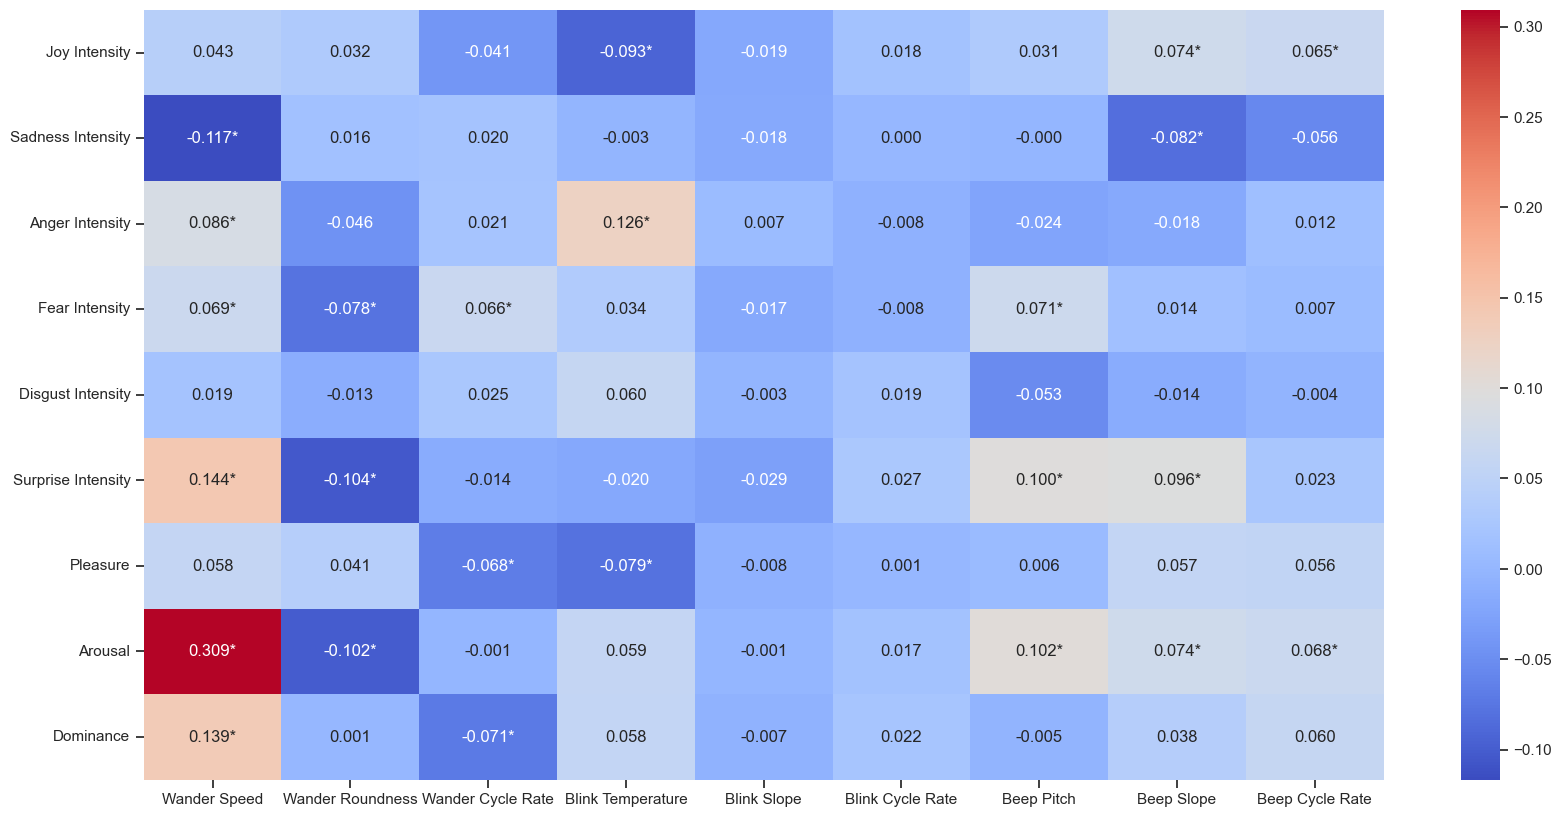

In [40]:
plt.figure(figsize=(20, 10))
xticklabels = [titles[var] for var in independent_variables]
yticklabels = [titles[var] for var in dependent_categorical_variables]
sns.heatmap(corr_matrix.iloc[num_independent_variables:, :num_independent_variables], annot=annot, xticklabels=xticklabels, yticklabels=yticklabels, cmap='coolwarm', fmt='')
plt.show()

In [41]:
mask = np.array([True] * num_independent_variables * num_dependent_categorical_variables)
mask[significance_mask] = False
mask = mask.reshape(num_independent_variables, num_dependent_categorical_variables).T

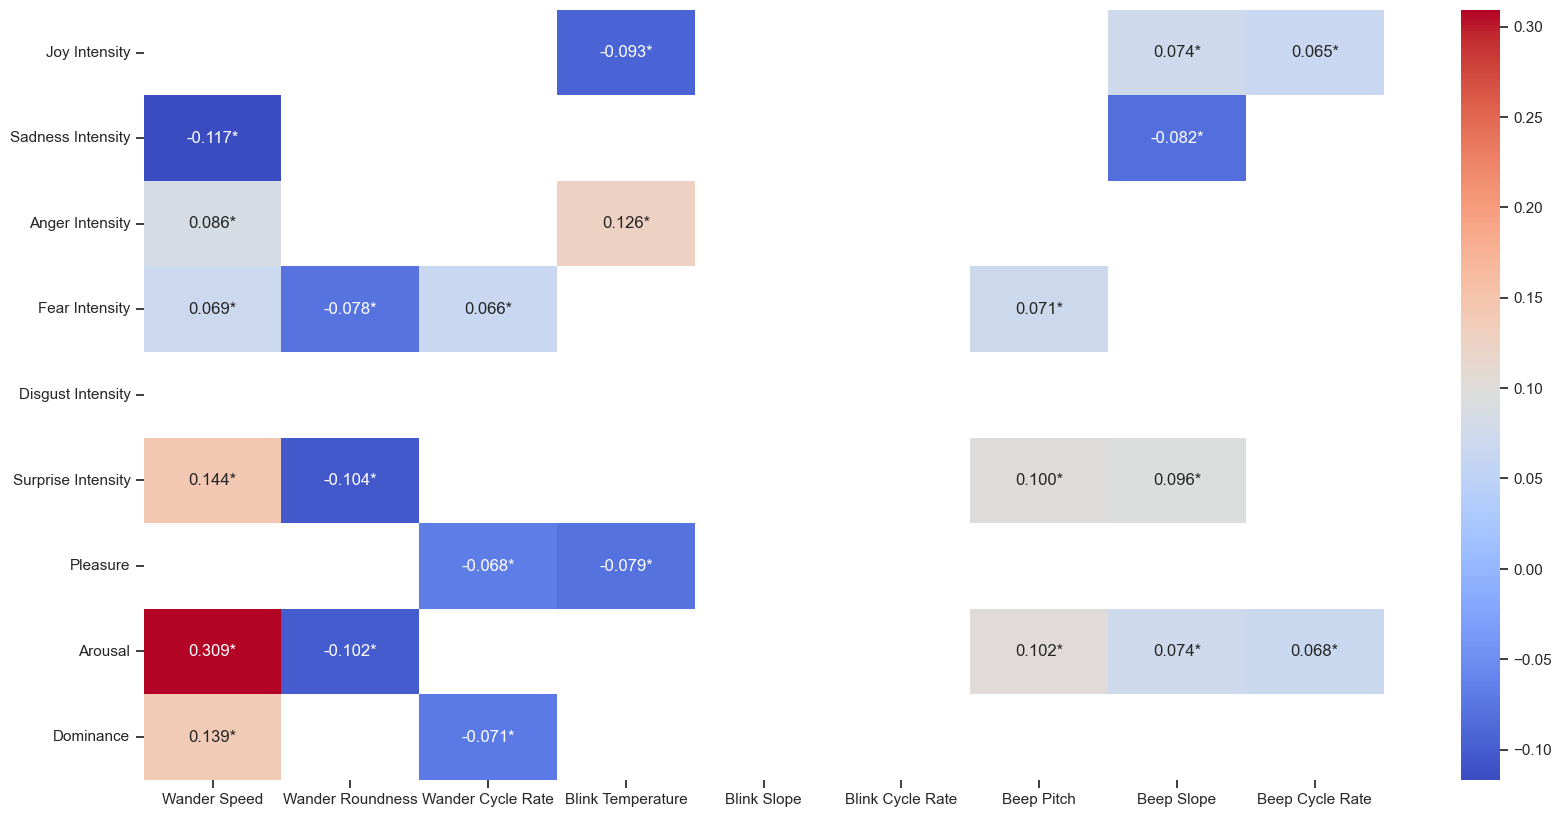

In [42]:
plt.figure(figsize=(20, 10))
xticklabels = [titles[var] for var in independent_variables]
yticklabels = [titles[var] for var in dependent_categorical_variables]
sns.heatmap(corr_matrix.iloc[num_independent_variables:, :num_independent_variables], annot=annot, xticklabels=xticklabels, yticklabels=yticklabels, cmap='coolwarm', fmt='', mask=mask)
plt.show()

In [47]:
# Initialize a results dictionary
model_results = {}

# Dependent variable
dependent_variable = 'arousal'

# Prepare the data
data = df[[dependent_variable] + independent_variables].dropna()
X = data[independent_variables]
y = data[dependent_variable]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the initial model with all predictors
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', maxiter=10000, disp=False)

# Evaluate model
print(f"\nResults for {dependent_variable} with forced entry of all independent variables\n")
print(result.summary())
print("\n\n")


Results for arousal with forced entry of all independent variables

                             OrderedModel Results                             
Dep. Variable:                arousal   Log-Likelihood:                -5138.6
Model:                   OrderedModel   AIC:                         1.031e+04
Method:            Maximum Likelihood   BIC:                         1.041e+04
Date:                Wed, 15 May 2024                                         
Time:                        16:13:48                                         
No. Observations:                2528                                         
Df Residuals:                    2511                                         
Df Model:                           9                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
wander_speed          0.0272      0.002     15.1

In [48]:
# Predict on train set
y_train_pred_prob = result.predict(X_train)
y_train_pred = y_train_pred_prob.idxmax(axis=1)

y_train_encoded = y_train.cat.codes
accuracy = accuracy_score(y_train_encoded, y_train_pred)
conf_matrix = confusion_matrix(y_train_encoded, y_train_pred)

print(f"Accuracy of the model on train data: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\n\n")

# Predict on test set
y_test_pred_prob = result.predict(X_test)
y_test_pred = y_test_pred_prob.idxmax(axis=1)

y_test_encoded = y_test.cat.codes
accuracy = accuracy_score(y_test_encoded, y_test_pred)
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

print(f"Accuracy of the model on test data: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy of the model on train data: 0.20
Confusion Matrix:
[[  1   0  48   0  82   0  22   0   0]
 [  1   0  36   0 110   0  19   0   0]
 [  2   0  47   0 220   0  57   0   0]
 [  3   0  43   0 162   0  65   0   0]
 [  0   0  47   0 281   0 159   0   0]
 [  2   0  30   0 227   0 117   0   0]
 [  1   0  20   0 215   0 180   0   0]
 [  0   0  10   0  88   0 123   0   0]
 [  0   0   4   0  41   0  65   0   0]]



Accuracy of the model on test data: 0.21
Confusion Matrix:
[[ 0  0 11  0 23  0  5  0  0]
 [ 1  0  9  0 27  0  4  0  0]
 [ 0  0 17  0 48  0 17  0  0]
 [ 0  0  9  0 46  0 13  0  0]
 [ 1  0 11  0 67  0 43  0  0]
 [ 0  0  9  0 50  0 35  0  0]
 [ 0  0  4  0 50  0 50  0  0]
 [ 0  0  0  0 28  0 27  0  0]
 [ 0  0  1  0 10  0 16  0  0]]


In [49]:
# Fit the initial model with all predictors
model = OrderedModel(y_train, X_train, distr='logit')
result = model.fit(method='bfgs', maxiter=10000, disp=False)

num_levels = len(y.cat.categories) - 1
current_pvalues = result.pvalues[:-num_levels]

threshold = 0.05  # Significance level to decide if a variable should stay

# Begin backward elimination
while any(current_pvalues > threshold):
    # Get the variable with the highest p-value
    highest_pval_var = current_pvalues.idxmax()
    
    # Remove the variable with the highest p-value
    X_train = X_train.drop(columns=[highest_pval_var])
    X_test = X_test.drop(columns=[highest_pval_var])
    
    # Refit the model without this variable
    model = OrderedModel(y_train, X_train, distr='logit')
    result = model.fit(method='bfgs', maxiter=10000, disp=False)
    
    current_pvalues = result.pvalues[:-num_levels]

    print(f"Results for {dependent_variable} after dropping {highest_pval_var}\n")
    print(result.summary())
    print("\n\n")

    # Predict on train set
    y_train_pred_prob = result.predict(X_train)
    y_train_pred = y_train_pred_prob.idxmax(axis=1)
    
    y_train_encoded = y_train.cat.codes
    accuracy = accuracy_score(y_train_encoded, y_train_pred)
    conf_matrix = confusion_matrix(y_train_encoded, y_train_pred)

# Store the results
model_results[dependent_variable] = result

# Display the summary
print(f"Results for {dependent_variable} after backward elimination:\n")
print(result.summary())
print("\n\n")

Results for arousal after dropping wander_cycle_rate

                             OrderedModel Results                             
Dep. Variable:                arousal   Log-Likelihood:                -5138.6
Model:                   OrderedModel   AIC:                         1.031e+04
Method:            Maximum Likelihood   BIC:                         1.040e+04
Date:                Wed, 15 May 2024                                         
Time:                        16:13:50                                         
No. Observations:                2528                                         
Df Residuals:                    2512                                         
Df Model:                           8                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
wander_speed          0.0272      0.002     15.126      0.000  

In [50]:
# Predict on train set
y_train_pred_prob = result.predict(X_train)
y_train_pred = y_train_pred_prob.idxmax(axis=1)

y_train_encoded = y_train.cat.codes
accuracy = accuracy_score(y_train_encoded, y_train_pred)
conf_matrix = confusion_matrix(y_train_encoded, y_train_pred)

print(f"Accuracy of the model after backward elimination on train data: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\n\n")

# Predict on test set
y_test_pred_prob = result.predict(X_test)
y_test_pred = y_test_pred_prob.idxmax(axis=1)

y_test_encoded = y_test.cat.codes
accuracy = accuracy_score(y_test_encoded, y_test_pred)
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

print(f"Accuracy of the model after backward elimination on test data: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy of the model after backward elimination on train data: 0.21
Confusion Matrix:
[[  1   0  48   0  85   0  19   0   0]
 [  1   0  39   0 107   0  19   0   0]
 [  2   0  52   0 216   0  56   0   0]
 [  3   0  46   0 165   0  59   0   0]
 [  0   0  45   0 295   0 147   0   0]
 [  2   0  29   0 231   0 114   0   0]
 [  1   0  20   0 217   0 178   0   0]
 [  0   0   8   0  91   0 122   0   0]
 [  0   0   4   0  42   0  64   0   0]]



Accuracy of the model after backward elimination on test data: 0.22
Confusion Matrix:
[[ 0  0 12  0 22  0  5  0  0]
 [ 1  0  8  0 28  0  4  0  0]
 [ 0  0 19  0 47  0 16  0  0]
 [ 0  0  9  0 45  0 14  0  0]
 [ 1  0 12  0 70  0 39  0  0]
 [ 0  0  9  0 50  0 35  0  0]
 [ 0  0  5  0 51  0 48  0  0]
 [ 0  0  1  0 28  0 26  0  0]
 [ 0  0  1  0 10  0 16  0  0]]
